In [1]:

!pip install segmentation-models-pytorch torch torchvision

import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Config:
    encoder_name = "resnet34"
    encoder_weights = "imagenet"
    
model = smp.Unet(
    encoder_name=Config.encoder_name,
    encoder_weights=None,  # Not loading imagenet weights
    in_channels=3,
    classes=1,
    activation=None
)

model_path = "/kaggle/input/segmentation-model/other/default/1/best_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))  # Load directly to device
model.eval()
model = model.to(device)

def preprocess_image(image_path, img_size=(640, 640)):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0).to(device) 

def predict(image_path):
    image_tensor = preprocess_image(image_path)
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()
    
    return pred_mask.squeeze().cpu().numpy()

def visualize_prediction(image_path):
    try:
        pred_mask = predict(image_path)
        original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        original_image = cv2.resize(original_image, (640, 640))
        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.title("Original Image")
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        
        plt.subplot(1, 3, 3)
        plt.imshow(original_image)
        plt.imshow(pred_mask, alpha=0.5, cmap='jet')
        plt.title("Overlay")
        
        plt.show()
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")


Using device: cuda


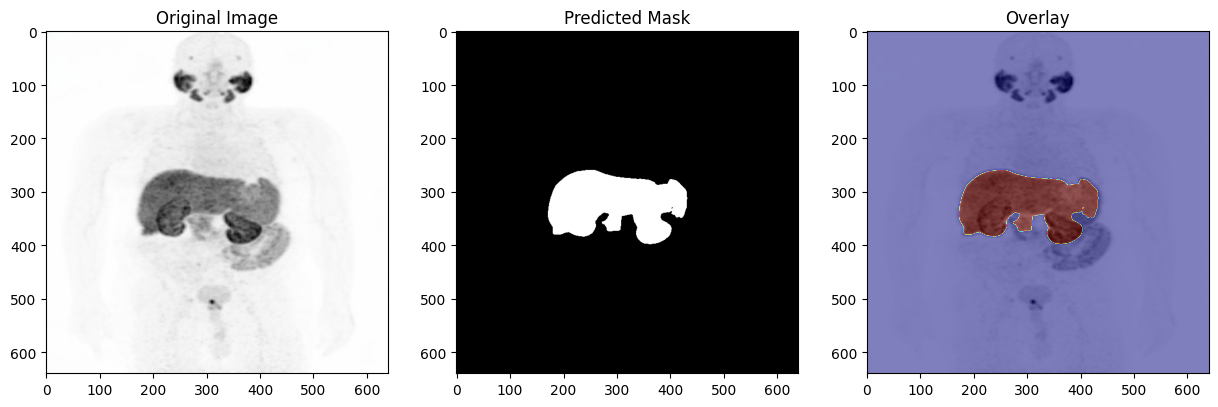

In [3]:
test_image_path = "/kaggle/input/pet-segmentation-dataset/image/50307PET_jpg.rf.605029c9a5a8d5f61b246beac788508c.jpg"  # Change this
visualize_prediction(test_image_path)